In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from model import *
from dataset import *
import util
import json
from collections import defaultdict

# Evaluate the model on the entire dataset
data = HD5Dataset('../data/data_dragon.hd5', seed=42, features=["FirstCharge", "CumulativeCharge", "Time",
            "VertexX", "VertexY", "VertexZ", "RecoX",
"RecoZ", "RecoAzimuth", "RecoZenith"])

In [2]:
with open('training/hd5-192956/config.json') as f:
    settings = json.load(f)

In [4]:
model = util.model_from_config(settings)

KeyError: 'distances_precomputed'

In [23]:
model.load_weights('training/hd5-192956/model_weights.h5')

ValueError: Layer #1 (named "gcnn_block_4" in the current model) was found to correspond to layer gcnn_block in the save file. However the new layer gcnn_block_4 expects 4 weights, but the saved weights have 2 elements.

In [22]:
model.weights

[<tf.Variable 'adjacency_matrix_layer_1/sigma:0' shape=(1,) dtype=float32, numpy=array([-1.4691414], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense_4/kernel:0' shape=(20, 64) dtype=float32, numpy=
 array([[ 0.15187138,  0.01706281, -0.09801832, ..., -0.17306906,
         -0.01989257,  0.04903027],
        [ 0.17938957, -0.05838764,  0.18573686, ..., -0.21103358,
         -0.07247046, -0.0810243 ],
        [ 0.13173634, -0.0747166 , -0.23833144, ...,  0.11874714,
         -0.03936706,  0.2592003 ],
        ...,
        [-0.09357294,  0.15010613,  0.2589006 , ..., -0.04595087,
         -0.1515443 , -0.0789469 ],
        [-0.12364402,  0.06284675, -0.10220759, ..., -0.1139022 ,
          0.20217529, -0.09782836],
        [-0.15895456,  0.20004615, -0.08295158, ..., -0.15626359,
          0.06291991, -0.14799821]], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense_4/bias:0' shape=(64,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [5]:
data = util.dataset_from_config(settings['dataset'])

Created memory map arrays.


In [6]:
test_idx = data._get_idx('test')

In [17]:
# Evaluate the model on all the data
batch_size = 128
logits_model = model.predict_generator(data.get_batches(batch_size=batch_size, dataset='test'),
                       steps=int(np.ceil(data.size(dataset='test') / batch_size)))

In [18]:
logits_model

array([[0.48002386],
       [0.48002386],
       [0.48002383],
       ...,
       [0.48002386],
       [0.48002386],
       [0.48002386]], dtype=float32)

In [19]:
np.unique(logits_model).shape

(4,)

In [16]:
y_model = (logits_model >= 0.5).astype(np.int)

In [17]:
np.unique(y_model)

array([0, 1])

In [18]:
y_model = y_model.squeeze()

In [22]:
# Get the pe counts (~charge) of the test data
total_charge = data.file['TotalCharge']['value'][test_idx]

In [23]:
y_gnd = data.targets[test_idx]
y_baseline = (data.delta_loglikelihood[test_idx] >= 2.0).astype(np.uint8)

In [24]:
total_charge_sorted = np.sort(total_charge)

In [25]:
# Find different cutoff values to check performance at different maximal energies by selecting the quantiles of the data
cutoffs = []
quantiles = []
for quantile in np.arange(0.00, 1.0, 0.01):
    quantile = 1.0 - quantile
    quantiles.append(quantile)
    cutoffs.append(total_charge_sorted[int(total_charge.shape[0] * quantile) - 1])

In [26]:
y_model.shape, y_gnd.shape

((220295,), (220295,))

In [27]:
def get_metrics(y_pred, y_gnd):
    acc = (y_pred == y_gnd).sum() / len(y_pred)
    tpr = (y_pred[y_gnd == 1] == 1).sum() / (y_gnd == 1).sum()
    tnr = (y_pred[y_gnd == 0] == 0).sum() / (y_gnd == 0).sum()
    ppr = (y_pred == 1).sum() / y_pred.shape[0]
    return acc, tpr, tnr, ppr

In [28]:
metrics = defaultdict(lambda: defaultdict(list))
for cutoff, quantile in zip(cutoffs, quantiles):
    mask = total_charge <= cutoff
    acc_baseline, tpr_baseline, tnr_baseline, ppr_baseline = get_metrics(y_baseline[mask], y_gnd[mask])
    metrics['baseline']['accuracy'].append(acc_baseline)
    metrics['baseline']['tpr'].append(tpr_baseline)
    metrics['baseline']['tnr'].append(tnr_baseline)
    metrics['baseline']['ppr'].append(ppr_baseline)
    acc_model, tpr_model, tnr_model, ppr_model = get_metrics(y_model[mask], y_gnd[mask])
    metrics['model']['accuracy'].append(acc_model)
    metrics['model']['tpr'].append(tpr_model)
    metrics['model']['tnr'].append(tnr_model)
    metrics['model']['ppr'].append(ppr_model)
    metrics['gnd']['ppr'].append((y_gnd[mask] == 1).sum() / y_gnd[mask].shape[0])

Text(0.5, 0.04, 'Integrated Charge (pe)')

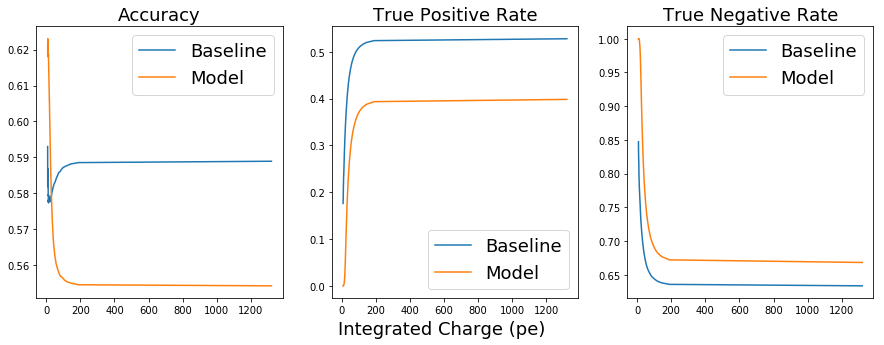

In [29]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax1.plot(cutoffs, metrics['baseline']['accuracy'], label='Baseline')
ax1.plot(cutoffs, metrics['model']['accuracy'], label='Model')
ax1.set_title('Accuracy', fontsize=18)
ax1.legend(fontsize=18)
ax2 = fig.add_subplot(132)
ax2.plot(cutoffs, metrics['baseline']['tpr'], label='Baseline')
ax2.plot(cutoffs, metrics['model']['tpr'], label='Model')
ax2.set_title('True Positive Rate', fontsize=18)
ax2.legend(fontsize=18)
ax3 = fig.add_subplot(133)
ax3.plot(cutoffs, metrics['baseline']['tnr'], label='Baseline')
ax3.plot(cutoffs, metrics['model']['tnr'], label='Model')
ax3.set_title('True Negative Rate', fontsize=18)
ax3.legend(fontsize=18)
fig.text(0.5, 0.04, 'Integrated Charge (pe)', ha='center', va='center', fontsize=18)



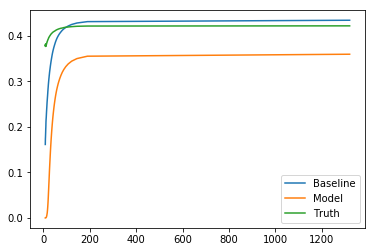

In [30]:
fig = plt.figure()
plt.plot(cutoffs, metrics['baseline']['ppr'], label='Baseline')
plt.plot(cutoffs, metrics['model']['ppr'], label='Model')
plt.plot(cutoffs, metrics['gnd']['ppr'], label='Truth')
plt.legend()


In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
adjacency_matrix_layer_1 (Ad multiple                  1         
_________________________________________________________________
gcnn_block_4 (GCNNBlock)     multiple                  1088      
_________________________________________________________________
gcnn_block_5 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
gcnn_block_6 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
gcnn_block_7 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
dense_2 (Dense)              multiple                  2080      
_________________________________________________________________
batch_normalization_v1_1 (Ba multiple                  128       
__________

In [32]:
model.weights

[<tf.Variable 'adjacency_matrix_layer_1/sigma:0' shape=(1,) dtype=float32, numpy=array([-1.1994079], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense/kernel:0' shape=(16, 64) dtype=float32, numpy=
 array([[-6.7605382e-01, -5.5014306e-01,  1.0545670e+00, ...,
          5.9158012e-02,  4.1892594e-01,  1.1311057e+00],
        [-1.1726910e-01, -3.6698148e-02, -2.5776282e-02, ...,
         -1.6091052e-01, -3.3308864e-03,  1.9296408e-02],
        [-4.5562524e-01, -7.2932534e-02,  3.4593046e-01, ...,
         -2.7987896e-02,  1.9500892e-01,  7.2564250e-01],
        ...,
        [ 2.4853425e-02,  5.2007634e-02,  1.5153764e-04, ...,
         -1.7101361e-01,  9.0077855e-03, -3.0158782e-01],
        [ 1.8562905e-01, -2.1861477e-01, -2.6344028e-01, ...,
         -1.6159213e-01,  5.9850786e-02, -1.6955628e-01],
        [ 1.4021096e-01, -1.9073695e-01, -1.7653483e-01, ...,
          9.7623197e-03, -1.5720429e-02, -1.2895808e-01]], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense/bias:0' shape=(6

In [131]:
np.unique(y_model)

array([0])

# Investigate attributes of the dataset

In [5]:
file = h5py.File('../data/data_dragon2.hd5')

In [13]:
idx = np.arange(file['TimeStdDeviation'].shape[0])
np.random.shuffle(idx)

In [14]:
samples = idx[:100000]

In [18]:
file.keys()

<KeysViewHDF5 ['ChargeFirstPulse', 'ChargeLastPulse', 'DeltaLLH', 'IC86_Dunkman_L6_SANTA_DirectCharge', 'IntegratedCharge', 'InteractionType', 'NumberChannels', 'NumberVertices', 'Offset', 'PDGEncoding', 'RecoAzimuth', 'RecoX', 'RecoY', 'RecoZ', 'RecoZenith', 'TimeFirstPulse', 'TimeLastPulse', 'TimeStdDeviation', 'TotalCharge', 'VertexX', 'VertexY', 'VertexZ', '__I3Index__']>

In [42]:
time_std_samples = file['TimeStdDeviation']['item'][samples]

In [38]:
time_std_samples = time_std_samples[time_std_samples < 1e-5]

In [43]:
time_std_samples

array([1.2055448e-03, 1.1102230e-16, 0.0000000e+00, ..., 0.0000000e+00,
       0.0000000e+00, 2.8057413e-03], dtype=float32)

(array([76768.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  4604.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,   264.]),
 array([0.00000000e+00, 2.22044600e-18, 4.44089200e-18, 6.66133800e-18,
        8.88178400e-18

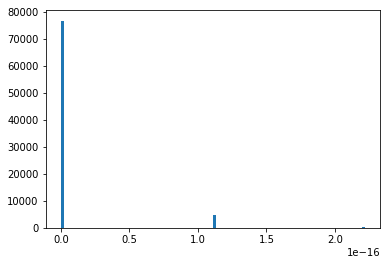

In [39]:
plt.hist(time_std_samples, bins=100)

In [40]:
charge_samples = file['ChargeFirstPulse']['item'][samples]

In [27]:
charge_samples = charge_samples[charge_samples <= 5]

(array([3072., 3387., 3761., 4108., 4557., 5143., 5673., 5869., 6233.,
           0., 6162., 6139., 5778., 5318., 4768., 4331., 3793., 3172.,
           0., 2688., 2301., 1654., 1348., 1078.,  891.,  731.,  589.,
           0.,  528.,  435.,  373.,  360.,  345.,  307.,  296.,  278.,
           0.,  259.,  222.,  214.,  202.,  214.,  174.,  185.,  134.,
           0.,  137.,  121.,  134.,   90.,  136.,   94.,   87.,   85.,
           0.,   75.,   86.,   84.,   47.,   75.,   48.,   55.,   42.,
           0.,   39.,   36.,   49.,   49.,   39.,   48.,   36.,   37.,
           0.,   32.,   27.,   32.,   32.,   41.,   35.,   43.,   27.,
           0.,   28.,   21.,   21.,   24.,   27.,   20.,   18.,   13.,
           0.,   24.,   15.,   21.,   18.,   13.,   21.,   15.,   14.,
          11.]),
 array([0.525     , 0.56949997, 0.61399996, 0.65849996, 0.70299995,
        0.74749994, 0.792     , 0.8365    , 0.881     , 0.9255    ,
        0.96999997, 1.0145    , 1.059     , 1.1035    , 1.148     

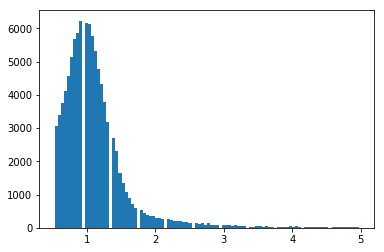

In [29]:
plt.hist(charge_samples, bins=100)

In [48]:
time_samples = file['TimeFirstPulse']['item'][samples]

In [51]:
time_samples_filtered = time_samples[time_samples > -0.002]

In [55]:
time_samples_filtered.std()

0.00030537526